<a href="https://colab.research.google.com/github/ParisaGhorbani/ParisaGhorbani/blob/main/t_SNE_sagittal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preparation**

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 13fYGpLBjW5kWg9xpe1ZbKBr6JliBzR3T

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=13fYGpLBjW5kWg9xpe1ZbKBr6JliBzR3T
From (redirected): https://drive.google.com/uc?id=13fYGpLBjW5kWg9xpe1ZbKBr6JliBzR3T&confirm=t&uuid=5d26ffd5-5f13-4707-bf2b-fbbbb64e4aee
To: /content/sagitall_1_5_train.zip
100% 33.3M/33.3M [00:00<00:00, 42.1MB/s]


if .rar

if .zip

In [ ]:
import zipfile
zip_file_path = '/content/sagitall_1_5_train.zip'
folder_path = '/content/sagitall_1_5_train'
# Extract the zip file to the specified folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

In [ ]:
import os
file_path = "/content/sagitall_1_5_train.zip"
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted successfully.")
else:
    print(f"{file_path} does not exist.")

/content/sagitall_1_5_train.zip has been deleted successfully.


Reorder datset folder!

# library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import zipfile

# **train & test data**

In [ ]:
train_dir = "/content/sagitall_1_5_train/sagitall_1_5_train"


In [ ]:
#calculate mean & STD
train_data = datasets.ImageFolder(root = train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.2721, 0.5242, 0.4012])
Calculated stds: tensor([0.3170, 0.3645, 0.3942])


In [ ]:
pretrained_means = [0.2721, 0.5242, 0.4012]
pretrained_stds= [0.3170, 0.3645, 0.3942]

## t-SNE

### resnet18

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.6MB/s]


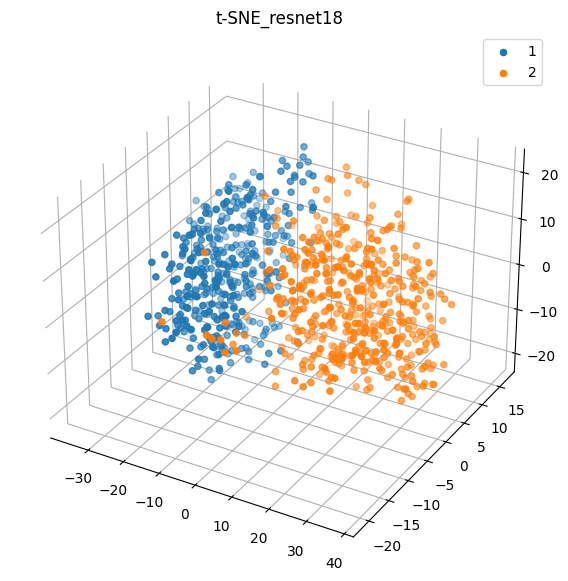

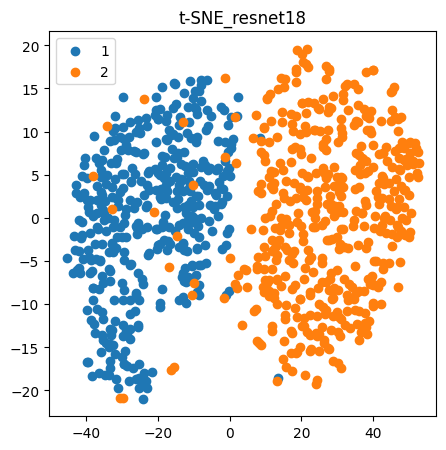

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# pretrained_means = [0.3744, 0.4508, 0.3808]
# pretrained_stds= [0.4204, 0.3466, 0.4231]


# Define image transformations
transform = transforms.Compose([
    transforms.Resize((
        256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
])

# Load custom image dataset
dataset = ImageFolder(root=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained model for feature extraction
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model.eval()
if torch.cuda.is_available():
    model.cuda()

# Extract features from images using the pre-trained model
def get_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, classes in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
            features.append(model(images).cpu().detach().numpy().reshape(images.shape[0], -1))
            labels.append(classes.numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

features, labels = get_features(dataloader)

# Apply t-SNE to reduce dimensionality of features
tsne = TSNE(n_components=3)
embeddings = tsne.fit_transform(features)

# Visualize the t-SNE embeddings
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(dataset.classes)):
    ax.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], embeddings[labels == i, 2], label=dataset.classes[i])

# Remove unnecessary elements from the plot
ax.grid(True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.zaxis.set_visible(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# Set the title and legend
plt.title('t-SNE_resnet18')
plt.legend()

# Save the plot as a PNG file
plt.savefig('t-SNE_resnet18_3.pdf')

# Show the plot
plt.show()

# Apply PCA to reduce dimensionality of features
ts = TSNE(n_components=2)
embedd = ts.fit_transform(features)
# Visualize the embeddings
plt.figure(figsize=(5, 5))
for i in range(len(dataset.classes)):
    plt.scatter(embedd[labels == i, 0], embedd[labels == i, 1], label=dataset.classes[i])
plt.legend()
plt.title('t-SNE_resnet18')
# Save the plot as a PNG file
plt.savefig('t-SNE_resnet18_2.pdf')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise distances in the t-SNE embedding space
tsne_distances = pairwise_distances(embeddings)

# Calculate cosine similarity matrix for the t-SNE embeddings
cosine_sim = cosine_similarity(embeddings)

# Calculate silhouette score in the t-SNE embedding space
silhouette_tsne = silhouette_score(tsne_distances, labels, metric='precomputed')

# Calculate Davies-Bouldin index in the t-SNE embedding space
davies_bouldin_tsne = davies_bouldin_score(embeddings, labels)

# Apply K-Means clustering to t-SNE embeddings
kmeans = KMeans(n_clusters=len(dataset.classes), random_state=0)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculate Adjusted Rand Index (ARI) for clustering
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(labels, cluster_labels)

# Calculate Inertia for K-Means clustering
inertia = kmeans.inertia_

# Calculate pairwise cosine similarities in the original feature space
cosine_sim_orig = cosine_similarity(features)

# Calculate the Frobenius norm of the difference between the original and t-SNE similarity matrices
frobenius_norm = np.linalg.norm(cosine_sim_orig - cosine_sim)

print("Silhouette Score (t-SNE):", silhouette_tsne)
print("Davies-Bouldin Index (t-SNE):", davies_bouldin_tsne)
print("Adjusted Rand Index (ARI) for Clustering:", ari)
print("Inertia for Clustering:", inertia)
print("Frobenius Norm of Similarity Matrices:", frobenius_norm)

Silhouette Score (t-SNE): 0.39747408
Davies-Bouldin Index (t-SNE): 0.9768018259670729
Adjusted Rand Index (ARI) for Clustering: 0.766102168425869
Inertia for Clustering: 203516.5
Frobenius Norm of Similarity Matrices: 937.6247


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###  vgg19

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:28<00:00, 20.2MB/s]


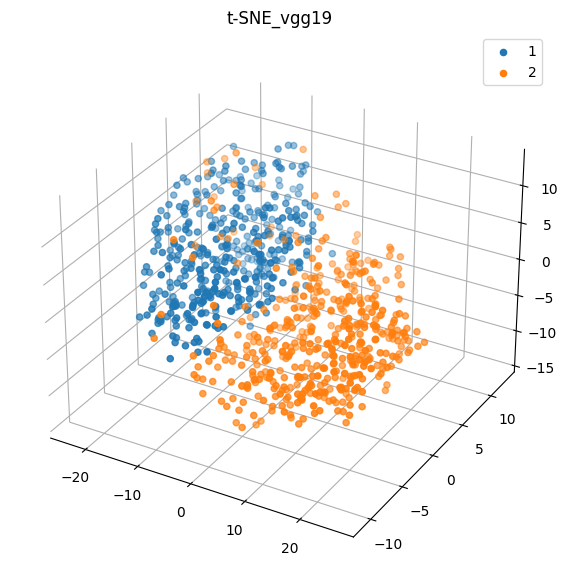

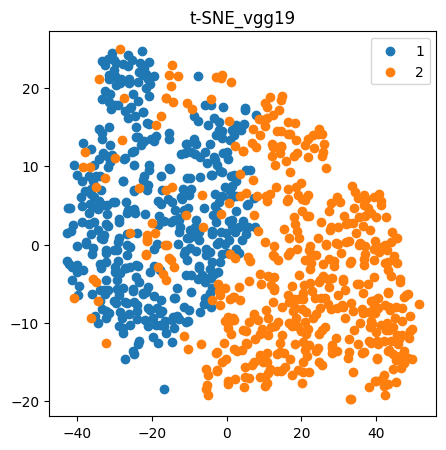

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# pretrained_means = [0.6190, 0.7493, 0.6781]
# pretrained_stds= [0.3942, 0.2770, 0.3786]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((
        256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
])

# Load custom image dataset
dataset = ImageFolder(root=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained model for feature extraction
model = torch.hub.load('pytorch/vision', 'vgg19', pretrained=True)
model.eval()
if torch.cuda.is_available():
    model.cuda()

# Extract features from images using the pre-trained model
def get_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, classes in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
            features.append(model(images).cpu().detach().numpy().reshape(images.shape[0], -1))
            labels.append(classes.numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

features, labels = get_features(dataloader)

# Apply t-SNE to reduce dimensionality of features
tsne = TSNE(n_components=3)
embeddings = tsne.fit_transform(features)

# Visualize the t-SNE embeddings
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(dataset.classes)):
    ax.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], embeddings[labels == i, 2], label=dataset.classes[i])

# Remove unnecessary elements from the plot
ax.grid(True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.zaxis.set_visible(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# Set the title and legend
plt.title('t-SNE_vgg19')
plt.legend()

# Save the plot as a PNG file
plt.savefig('t-SNE_vgg19_3.pdf')

# Show the plot
plt.show()

# Apply PCA to reduce dimensionality of features
ts = TSNE(n_components=2)
embedd = ts.fit_transform(features)
# Visualize the embeddings
plt.figure(figsize=(5, 5))
for i in range(len(dataset.classes)):
    plt.scatter(embedd[labels == i, 0], embedd[labels == i, 1], label=dataset.classes[i])
plt.legend()
plt.title('t-SNE_vgg19')
# Save the plot as a PNG file
plt.savefig('t-SNE_vgg19_2.pdf')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise distances in the t-SNE embedding space
tsne_distances = pairwise_distances(embeddings)

# Calculate cosine similarity matrix for the t-SNE embeddings
cosine_sim = cosine_similarity(embeddings)

# Calculate silhouette score in the t-SNE embedding space
silhouette_tsne = silhouette_score(tsne_distances, labels, metric='precomputed')

# Calculate Davies-Bouldin index in the t-SNE embedding space
davies_bouldin_tsne = davies_bouldin_score(embeddings, labels)

# Apply K-Means clustering to t-SNE embeddings
kmeans = KMeans(n_clusters=len(dataset.classes), random_state=0)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculate Adjusted Rand Index (ARI) for clustering
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(labels, cluster_labels)

# Calculate Inertia for K-Means clustering
inertia = kmeans.inertia_

# Calculate pairwise cosine similarities in the original feature space
cosine_sim_orig = cosine_similarity(features)

# Calculate the Frobenius norm of the difference between the original and t-SNE similarity matrices
frobenius_norm = np.linalg.norm(cosine_sim_orig - cosine_sim)

print("Silhouette Score (t-SNE):", silhouette_tsne)
print("Davies-Bouldin Index (t-SNE):", davies_bouldin_tsne)
print("Adjusted Rand Index (ARI) for Clustering:", ari)
print("Inertia for Clustering:", inertia)
print("Frobenius Norm of Similarity Matrices:", frobenius_norm)

Silhouette Score (t-SNE): 0.3580105
Davies-Bouldin Index (t-SNE): 1.0358687895939624
Adjusted Rand Index (ARI) for Clustering: 0.5873377030660841
Inertia for Clustering: 84350.0078125
Frobenius Norm of Similarity Matrices: 980.7714


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### EfficientnetB0

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=e439a6b7b752443444800eb8f180e371499ce7e4b295e9897b389da653124010
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 113MB/s] 


Loaded pretrained weights for efficientnet-b0


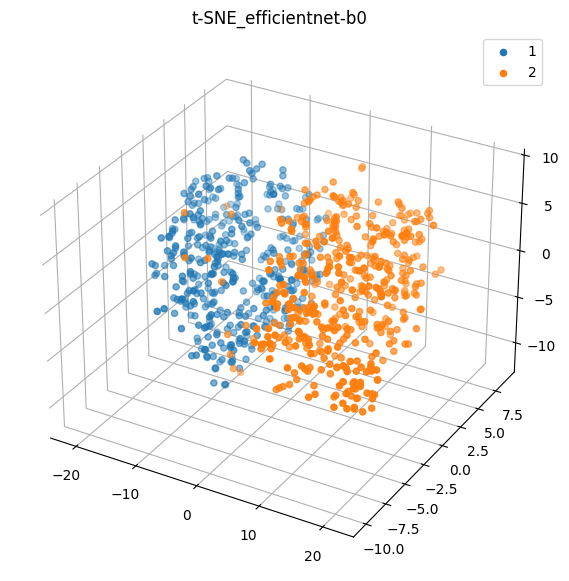

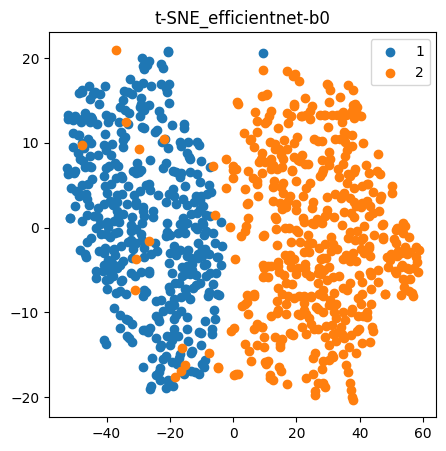

In [ ]:
! pip install efficientnet_pytorch
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from efficientnet_pytorch import EfficientNet

# pretrained_means = [0.6190, 0.7493, 0.6781]
# pretrained_stds= [0.3942, 0.2770, 0.3786]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((
        256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
])

# Load custom image dataset
dataset = ImageFolder(root=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load pre-trained model for feature extraction
model = EfficientNet.from_pretrained('efficientnet-b0')
model.eval()
if torch.cuda.is_available():
    model.cuda()

# Extract features from images using the pre-trained model
def get_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, classes in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
            features.append(model(images).cpu().detach().numpy().reshape(images.shape[0], -1))
            labels.append(classes.numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

features, labels = get_features(dataloader)

# Apply t-SNE to reduce dimensionality of features
tsne = TSNE(n_components=3)
embeddings = tsne.fit_transform(features)

# Visualize the t-SNE embeddings
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(dataset.classes)):
    ax.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], embeddings[labels == i, 2], label=dataset.classes[i])

# Remove unnecessary elements from the plot
ax.grid(True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.zaxis.set_visible(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)

# Set the title and legend
plt.title('t-SNE_efficientnet-b0')
plt.legend()

# Save the plot as a PNG file
plt.savefig('t-SNE_efficientnet-b0_3.pdf')

# Show the plot
plt.show()

# Apply PCA to reduce dimensionality of features
ts = TSNE(n_components=2)
embedd = ts.fit_transform(features)
# Visualize the embeddings
plt.figure(figsize=(5, 5))
for i in range(len(dataset.classes)):
    plt.scatter(embedd[labels == i, 0], embedd[labels == i, 1], label=dataset.classes[i])
plt.legend()
plt.title('t-SNE_efficientnet-b0')
# Save the plot as a PNG file
plt.savefig('t-SNE_efficientnet-b0_2.pdf')
plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise distances in the t-SNE embedding space
tsne_distances = pairwise_distances(embeddings)

# Calculate cosine similarity matrix for the t-SNE embeddings
cosine_sim = cosine_similarity(embeddings)

# Calculate silhouette score in the t-SNE embedding space
silhouette_tsne = silhouette_score(tsne_distances, labels, metric='precomputed')

# Calculate Davies-Bouldin index in the t-SNE embedding space
davies_bouldin_tsne = davies_bouldin_score(embeddings, labels)

# Apply K-Means clustering to t-SNE embeddings
kmeans = KMeans(n_clusters=len(dataset.classes), random_state=0)
cluster_labels = kmeans.fit_predict(embeddings)

# Calculate Adjusted Rand Index (ARI) for clustering
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(labels, cluster_labels)

# Calculate Inertia for K-Means clustering
inertia = kmeans.inertia_

# Calculate pairwise cosine similarities in the original feature space
cosine_sim_orig = cosine_similarity(features)

# Calculate the Frobenius norm of the difference between the original and t-SNE similarity matrices
frobenius_norm = np.linalg.norm(cosine_sim_orig - cosine_sim)

print("Silhouette Score (t-SNE):", silhouette_tsne)
print("Davies-Bouldin Index (t-SNE):", davies_bouldin_tsne)
print("Adjusted Rand Index (ARI) for Clustering:", ari)
print("Inertia for Clustering:", inertia)
print("Frobenius Norm of Similarity Matrices:", frobenius_norm)

Silhouette Score (t-SNE): 0.5015097
Davies-Bouldin Index (t-SNE): 0.743259905043933
Adjusted Rand Index (ARI) for Clustering: 0.8855585227939391
Inertia for Clustering: 51004.79296875
Frobenius Norm of Similarity Matrices: 969.8684


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
